# A/B testing for an online store

**Project description:**
This project recreates analysis for a big online store. Marketing department has complied a list of of hypotheses that may help boost revenue. First of all, hypotheses should be prioritized using ICE and RICE frameworks, and one of them will be tested with the experiment. It's results to be analyzed with A/B testing approach.

**Description of the data:**

* Hypotheses dataset:

`Hypotheses` — brief descriptions of the hypotheses

`Reach` — user reach, on a scale of one to ten

`Impact` — impact on users, on a scale of one to ten

`Confidence` — confidence in the hypothesis, on a scale of one to ten

`Effort` — the resources required to test a hypothesis, on a scale of one to ten. The higher the Effort value, the more resource-intensive the test.

* Orders dataset:

`transactionId` — order identifier

`visitorId` — identifier of the user who placed the order

`date` — of the order

`revenue` — from the order

`group` — the A/B test group that the user belongs to

* Visits dataset:

`date` — date

`group` — A/B test group

`visits` — the number of visits on the date specified in the A/B test group specified

# Initialization

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats

# Data preprocessing

For all datasets I will firstly download a part of the dataset, discovering the datatypes, separators, columns' names and etc, and then I will fix all the found issues

* **Hypotheses dataset**

In [2]:
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv',nrows=500)
hypotheses.info(memory_usage='deep')
hypotheses.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 1 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Hypothesis;Reach;Impact;Confidence;Effort  9 non-null      object
dtypes: object(1)
memory usage: 1.4 KB


,Hypothesis;Reach;Impact;Confidence;Effort
0,Add two new channels for attracting traffic. T...
1,Launch your own delivery service. This will sh...
2,Add product recommendation blocks to the store...
3,Change the category structure. This will incre...
4,Change the background color on the main page. ...


Separator needs to be fixed:

In [3]:
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv',nrows=500, sep = ';')
hypotheses.info(memory_usage='deep')
hypotheses.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 1.6 KB


,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


As datatypes of the columns are okay, only columns' names should be fixed to start working with the dataset:

In [4]:
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep = ';')
hypotheses.columns = [x.replace(' ','_').lower() for x in hypotheses.columns]
print(hypotheses.duplicated().sum())
print(hypotheses.head())

0
                                          hypothesis  reach  impact  \
0  Add two new channels for attracting traffic. T...      3      10   
1  Launch your own delivery service. This will sh...      2       5   
2  Add product recommendation blocks to the store...      8       3   
3  Change the category structure. This will incre...      8       3   
4  Change the background color on the main page. ...      3       1   

   confidence  effort  
0           8       6  
1           4      10  
2           7       3  
3           3       8  
4           1       1  


Dataset is ready

* **Orders dataset**

In [5]:
orders = pd.read_csv('/datasets/orders_us.csv',nrows=500)
orders.info(memory_usage='deep')
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  500 non-null    int64  
 1   visitorId      500 non-null    int64  
 2   date           500 non-null    object 
 3   revenue        500 non-null    float64
 4   group          500 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 72.9 KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


* column `date` should be read as datetime type
* columns `transactionId` and `visitorId` will be renamed for easiness

In [6]:
orders = pd.read_csv('/datasets/orders_us.csv', parse_dates=['date']) 
orders.info(memory_usage='deep')
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 105.3 KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [7]:
orders.columns = ['transaction_id','uid','date','revenue','group']

Orders dataset is ready

* **Visits dataset**

In [8]:
visits = pd.read_csv('/datasets/visits_us.csv',nrows=500)
visits.info(memory_usage='deep')
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 8.2 KB


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


* date should be turned into datetime datatype

In [9]:
visits = pd.read_csv('/datasets/visits_us.csv', parse_dates=['date']) 
visits.info(memory_usage='deep')
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 4.6 KB


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Visits dataset is ready

# Data analysis

## Prioritizing Hypotheses
### ICE framework application

*ICE_score = Impact * Confidence / Effort*

In [10]:
pd.options.display.max_colwidth = 210

In [11]:
hypotheses['ICE'] = round(hypotheses.impact*hypotheses.confidence/hypotheses.effort,2)

In [12]:
hypotheses[['hypothesis','ICE']].sort_values(by='ICE', ascending = False)

,hypothesis,ICE
8,Launch a promotion that gives users discounts on their birthdays,16.20
0,Add two new channels for attracting traffic. This will bring 30% more users,13.33
7,Add a subscription form to all the main pages. This will help you compile a mailing list,11.20
6,Show banners with current offers and sales on the main page. This will boost conversion,8.00
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,7.00
1,Launch your own delivery service. This will shorten delivery time,2.00
5,Add a customer review page. This will increase the number of orders,1.33
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,1.12
4,Change the background color on the main page. This will increase user engagement,1.00


The top-3 most prioritized hypotheses are 8, 0 and 7 judging by the ICE score

### RICE framework application
*ICE_score = Reach * Impact * Confidence / Effort*

In [13]:
hypotheses['RICE'] = round(hypotheses.reach*hypotheses.impact*hypotheses.confidence/hypotheses.effort,2)

In [14]:
hypotheses[['hypothesis','RICE']].sort_values(by='RICE', ascending = False)

,hypothesis,RICE
7,Add a subscription form to all the main pages. This will help you compile a mailing list,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,40.0
8,Launch a promotion that gives users discounts on their birthdays,16.2
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,9.0
1,Launch your own delivery service. This will shorten delivery time,4.0
5,Add a customer review page. This will increase the number of orders,4.0
4,Change the background color on the main page. This will increase user engagement,3.0


The biggest priority are shared by hypotheses 7, 2 and 0 judging by the RICE score

**Conclusion**

Hypotheses 0 and 7 are in top-3 most prioritized hypotheses judging by the ICE and RICE scores, saying, that them are to be the most interesting for testing. And hypothesis 4 is the least priorityzed in both cases.

The differences are observed because of RICE score also implements the *Reach* factor (showing, how many users will be affected by the experiment), that is lacking for ICE score. 

I would prefer to work with the hypotheses, chosen by the RICE score, as this framework takes more information into accaunt, than ICE. So, the most prioritized hypothesis in my opininon is 7, being the absolute undoubtful leader by the RICE score.

Hypothesis 7 itself is stated in the next way:

In [15]:
hypotheses['hypothesis'].loc[7]

'Add a subscription form to all the main pages. This will help you compile a mailing list'

<a id='1'></a>

## Raw data analysis 

First of all I will check, if the sample was collected more or less correctly in terms of groups' sizes: 

In [16]:
print('Number of recorded orders is',orders.shape[0])
print('Length of the experiment is',len(visits['date'].unique()),'days')
print('Experiment started at',visits['date'].min(),'and finished at',visits['date'].max())
print('Groups in the experint:',visits['group'].unique())
print('Number of visitors in group A',visits[visits['group']=='A']['visits'].sum())
print('Number of visitors in group B',visits[visits['group']=='B']['visits'].sum())
print('Number of buyers in group A',orders[orders['group']=='A'].agg({'uid':'nunique'})[0])
print('Number of buyers in group B',orders[orders['group']=='B'].agg({'uid':'nunique'})[0])

Number of recorded orders is 1197
Length of the experiment is 31 days
Experiment started at 2019-08-01 00:00:00 and finished at 2019-08-31 00:00:00
Groups in the experint: ['A' 'B']
Number of visitors in group A 18736
Number of visitors in group B 18916
Number of buyers in group A 503
Number of buyers in group B 586


In [17]:
data = {'group': ['A','B'], 
        'n_visitors': [visits[visits['group']=='A']['visits'].sum(),visits[visits['group']=='B']['visits'].sum()],
       'n_buyers':[orders[orders['group']=='A'].agg({'uid':'nunique'})[0], orders[orders['group']=='B'].agg({'uid':'nunique'})[0]]}
pd.DataFrame.from_dict(data)

,group,n_visitors,n_buyers
0,A,18736,503
1,B,18916,586


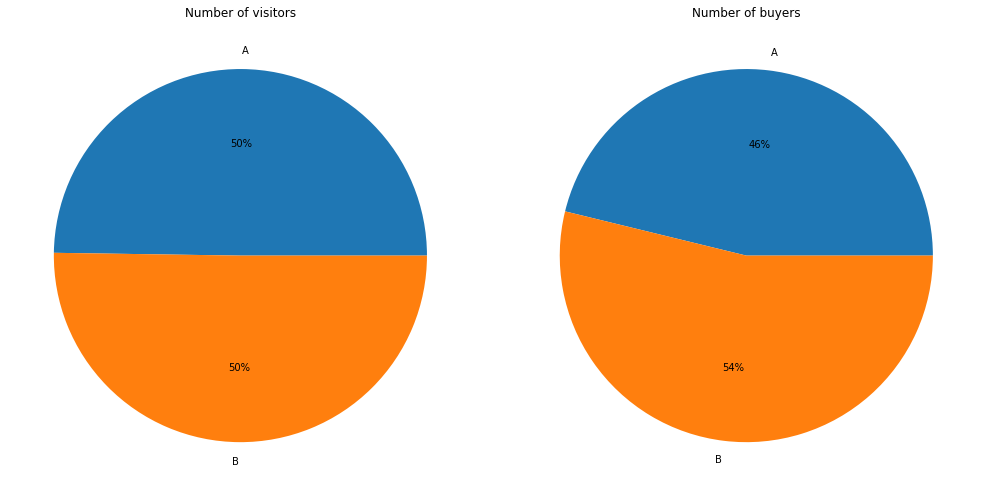

In [18]:
plt.figure(figsize = (15,7))

plt.subplot(1, 2, 1)
plt.pie(x = data['n_visitors'], labels = data['group'], autopct='%.0f%%')
plt.title("Number of visitors")
plt.tight_layout()
plt.grid()

plt.subplot(1, 2, 2)
plt.pie(x = data['n_buyers'], labels = data['group'], autopct='%.0f%%')
plt.title("Number of buyers")
plt.tight_layout()
plt.grid()

plt.show()

So, the experiment was condacted for 31 day. While number of visitors is nearly the same for both groups, there is an observable difference in number of buyers in groups.

Total raw conversion rates are:

In [19]:
print('Total overall conversion rate of group A is',"{0:.3f}".format(orders[orders['group']=='A'].agg({'uid':'nunique'})[0]/visits[visits['group']=='A']['visits'].sum()))
print('Total overall conversion rate of group B is',"{0:.3f}".format(orders[orders['group']=='B'].agg({'uid':'nunique'})[0]/visits[visits['group']=='B']['visits'].sum()))

Total overall conversion rate of group A is 0.027
Total overall conversion rate of group B is 0.031


So, overall total conversion rate is greater for group B. This needs to be studied deeper.

Samples seems to be okay.
### Cumulative revenue study
Preparing the agregated subset for the analysys. 

First of all the list of unique date-group combination should be prepared:

In [20]:
datesGroups = orders[['date', 'group']].drop_duplicates()

Then `ordersAggregated` subset with cumulative revenue calculation should be created:

In [21]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': pd.Series.nunique,
            'uid': pd.Series.nunique,
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

ordersAggregated.head()

,date,group,transaction_id,uid,revenue
55,2019-08-01,A,24,20,2356.8
66,2019-08-01,B,21,20,1620.0
175,2019-08-02,A,44,38,3860.3
173,2019-08-02,B,45,43,4243.8
291,2019-08-03,A,68,62,5675.5


And the same for `visitorsAggregated`:

In [22]:
visitorsAggregated = datesGroups.apply(
    lambda x: visits[
        np.logical_and(
            visits['date'] <= x['date'], visits['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visits': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated.head()

,date,group,visits
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


And a aggregated cumulative dataset is ready to be created:

In [23]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, on=['date', 'group'])

cumulativeData.columns = ['date','group','orders','buyers','revenue','visitors']

cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,2356.8,719
1,2019-08-01,B,21,20,1620.0,713
2,2019-08-02,A,44,38,3860.3,1338
3,2019-08-02,B,45,43,4243.8,1294
4,2019-08-03,A,68,62,5675.5,1845


Plotting the graph of the cumulative revenue by group:

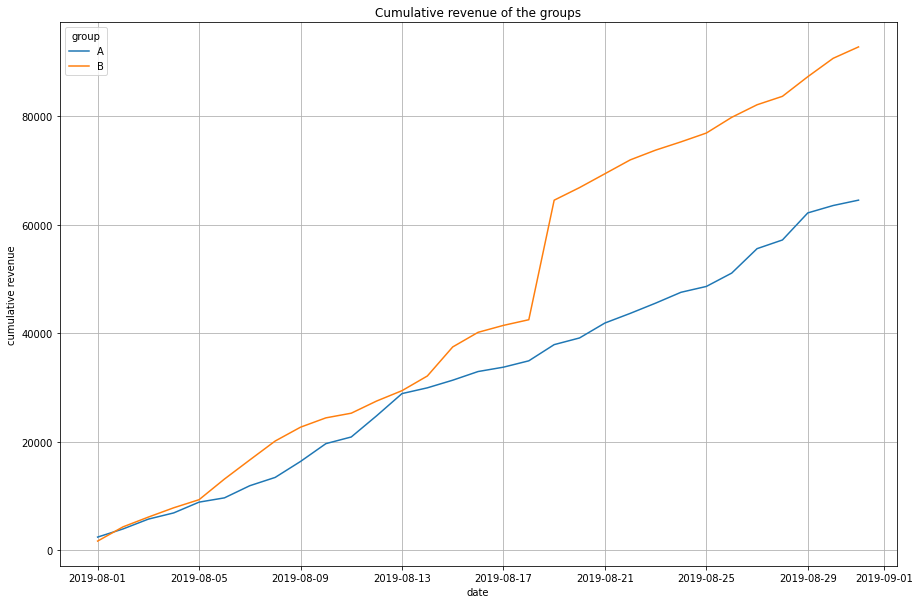

In [24]:
plt.figure(figsize = (15,10))
sns.lineplot(data = cumulativeData, x = 'date', y = 'revenue', hue = 'group')
plt.title('Cumulative revenue of the groups')
plt.grid()
plt.ylabel('cumulative revenue')
plt.show()

**Conclusion**

This graph clearly shows that group B has bigger cumulative revenue after a great jump in it nearly at the date 2019-08-18, showing the big amount of money gained at that time. Before that, group B was also a leader, but with a samller gap. This looks suspictious, as it could be an outlying event, that led for such results.

### Cumulative average order size

Preparing column with average order size in `cumulativeData` dataset and plotting a graph:

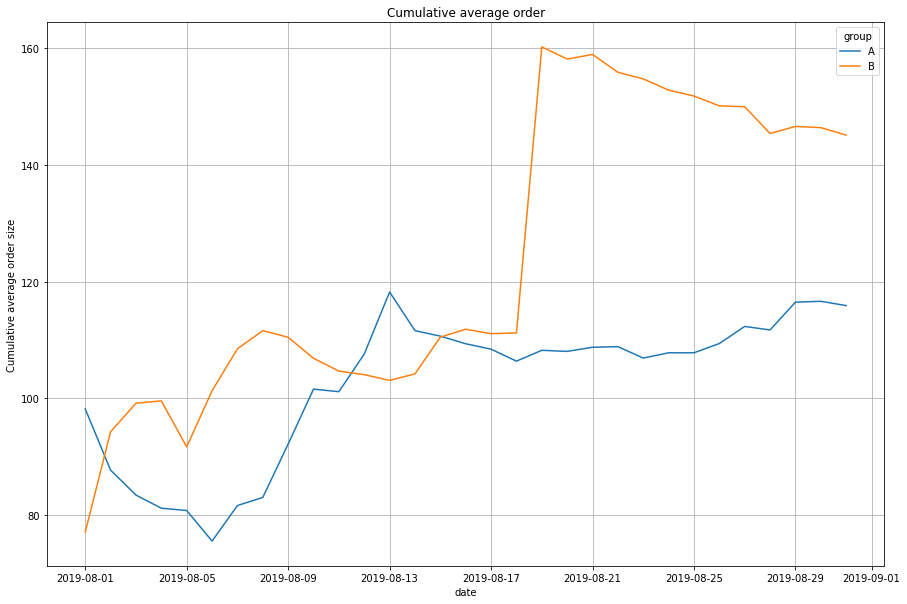

In [25]:
cumulativeData['avg_order']=cumulativeData['revenue']/cumulativeData['orders']

plt.figure(figsize = (15,10))
sns.lineplot(data = cumulativeData, x = 'date', y = 'avg_order', hue = 'group')
plt.title('Cumulative average order')
plt.grid()
plt.ylabel('Cumulative average order size')
plt.show()

**Conclusion**

This graph shows, that group B has bigger cumulative average order size. Both groups has significant rises and drops the first part of the experiment. Again the date 2019-08-18 looks suspisious because of the enormouse increasemet of the B-group's metric in it. And group A shows a decrease of the cumulative average order size in the start of the studied period up to 2019-08-06 with a major rise after it. Both groups show more or less stabilized metric after 2019-08-18.

### Relative difference in cumulative average order size

For this plot a number of manipulations is needed:
* new subset with a different architecture, where information on groups A and B are in different columns;
* new column with calculated relative difference

In [26]:
cumulativeRevenueA = cumulativeData.query('group == "A"')
cumulativeRevenueB = cumulativeData.query('group == "B"')

mergedCumulativeRevenue = cumulativeRevenueA[['revenue','orders','date']].merge(cumulativeRevenueB[['revenue','orders','date']], on='date', how='left', suffixes=['_A', '_B'])

mergedCumulativeRevenue.head()

,revenue_A,orders_A,date,revenue_B,orders_B
0,2356.8,24,2019-08-01,1620.0,21
1,3860.3,44,2019-08-02,4243.8,45
2,5675.5,68,2019-08-03,6050.6,61
3,6822.1,84,2019-08-04,7767.9,78
4,8810.2,109,2019-08-05,9262.9,101


In [27]:
mergedCumulativeRevenue['cum_diff'] = (mergedCumulativeRevenue['revenue_B']/mergedCumulativeRevenue['orders_B'])/(mergedCumulativeRevenue['revenue_A']/mergedCumulativeRevenue['orders_A'])-1

mergedCumulativeRevenue.head()

,revenue_A,orders_A,date,revenue_B,orders_B,cum_diff
0,2356.8,24,2019-08-01,1620.0,21,-0.214431
1,3860.3,44,2019-08-02,4243.8,45,0.074915
2,5675.5,68,2019-08-03,6050.6,61,0.188429
3,6822.1,84,2019-08-04,7767.9,78,0.226225
4,8810.2,109,2019-08-05,9262.9,101,0.134662


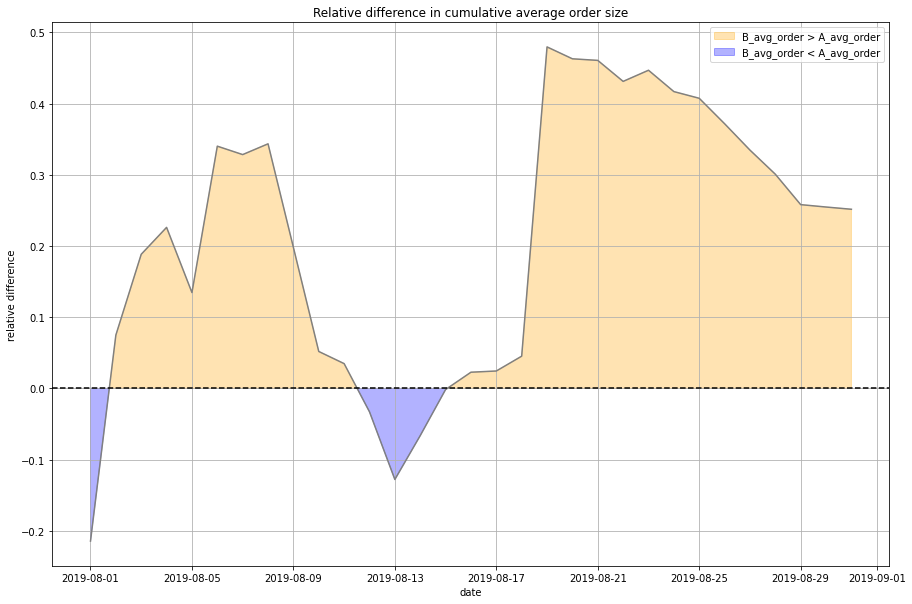

In [28]:
plt.figure(figsize = (15,10))

plt.plot(mergedCumulativeRevenue['date'], mergedCumulativeRevenue['cum_diff'], color = 'gray')

plt.fill_between(mergedCumulativeRevenue['date'], mergedCumulativeRevenue['cum_diff'], 0, where = (mergedCumulativeRevenue['cum_diff']>0), alpha=0.30, color='orange', interpolate=True, label='B_avg_order > A_avg_order')
plt.fill_between(mergedCumulativeRevenue['date'], mergedCumulativeRevenue['cum_diff'], 0, where = (mergedCumulativeRevenue['cum_diff']<=0), alpha=0.30, color='blue', interpolate=True, label='B_avg_order < A_avg_order')
plt.title('Relative difference in cumulative average order size')
plt.xlabel('date')
plt.ylabel('relative difference')

plt.legend()
plt.axhline(y=0, color='black', linestyle='--') 
plt.grid()
plt.show()

**Conclusion**

Clearly, cumulative average order size tends to be greater in group B, only at the very beginning and in a small period of time  in the middle of the observed period it was smaller than in group A. 

Also it is difficult to say, if the sample has managed to stabilize before the experiment finished, as metric of relative difference in cumulative average order size is still fluctuating at the latest points of the studied data.

### Conversion rate

New metric is calculated in new column:

In [29]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

Plotting the graph:

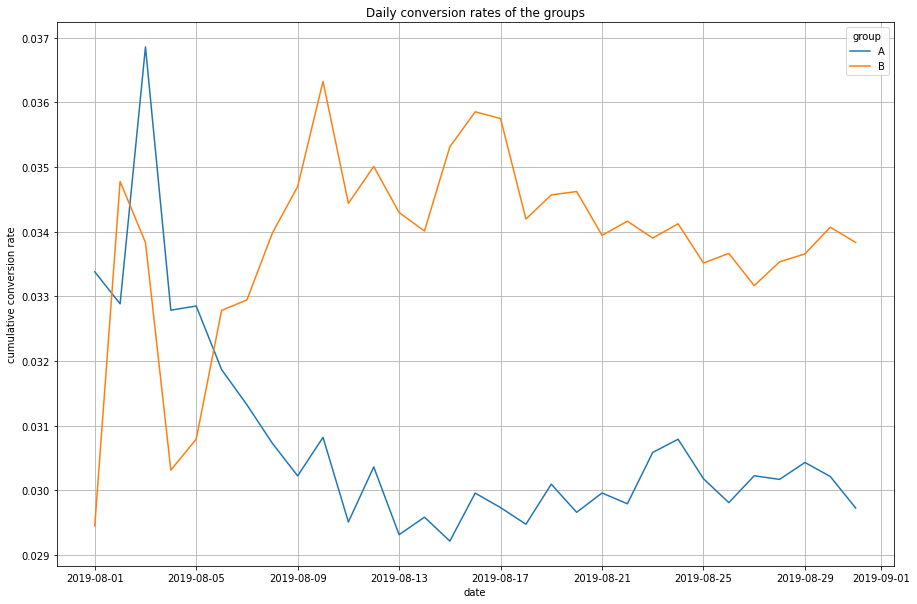

In [30]:
plt.figure(figsize = (15,10))
sns.lineplot(data = cumulativeData, x = 'date', y = 'conversion', hue = 'group')
plt.title('Daily conversion rates of the groups')
plt.grid()
plt.ylabel('cumulative conversion rate')
plt.show()

Conversion rates graph clearly shows, that group B dominates with a conversion of approximately 0.034 by the end of the period, while A has conversion rate approx 0.03. Also both groups show nearly simmetrical behavior.

And relative difference between the cumulative conversion rate of group B compared with that of group A can be plotted. For that new manipulations with the data are needed:

In [31]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

cumulativeConversionA = cumulativeData.query('group == "A"')
cumulativeConversionB = cumulativeData.query('group == "B"')

mergedCumulativeConversion = cumulativeConversionA[['conversion','date']].merge(cumulativeConversionB[['conversion','date']], on='date', how='left', suffixes=['_A', '_B'])

mergedCumulativeConversion['conv_diff'] = mergedCumulativeConversion['conversion_B']/mergedCumulativeConversion['conversion_A']-1

Plotting the graph:

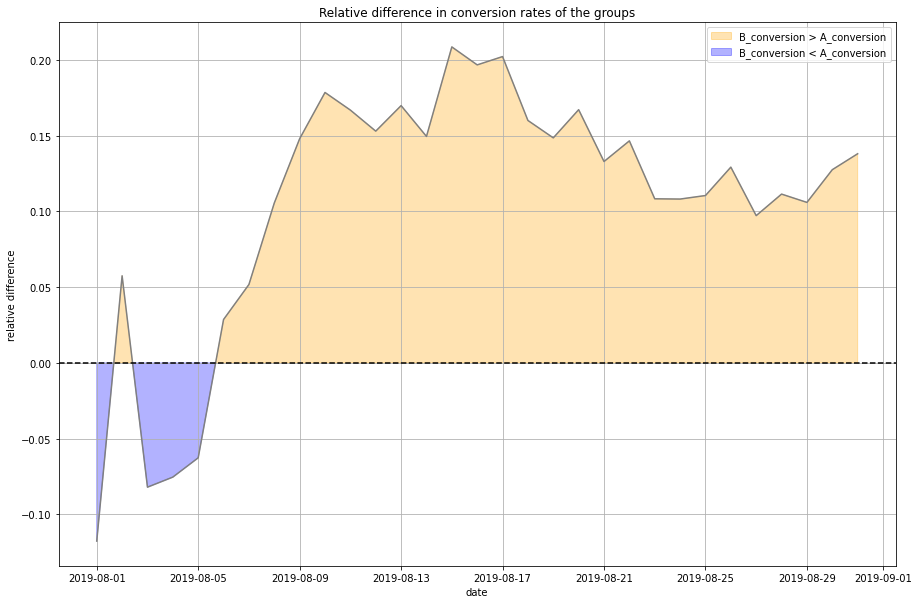

In [32]:
plt.figure(figsize = (15,10))

plt.plot(mergedCumulativeConversion['date'], mergedCumulativeConversion['conv_diff'], color = 'gray')

plt.fill_between(mergedCumulativeConversion['date'], mergedCumulativeConversion['conv_diff'], 0, where = (mergedCumulativeConversion['conv_diff']>0), alpha=0.30, color='orange', interpolate=True, label='B_conversion > A_conversion')
plt.fill_between(mergedCumulativeConversion['date'], mergedCumulativeConversion['conv_diff'], 0, where = (mergedCumulativeConversion['conv_diff']<=0), alpha=0.30, color='blue', interpolate=True, label='B_conversion < A_conversion')
plt.title('Relative difference in conversion rates of the groups')
plt.xlabel('date')
plt.ylabel('relative difference')

plt.legend()
plt.axhline(y=0, color='black', linestyle='--') 
plt.grid()
plt.show()

**Conclusion**

After a dramatic rise in 2019-08-06 we can see, that group B is confidently leading in conversion rate with about 0.14 times greater metric value. This result is not very stable, it fluctuatuates from 0.21 at maximum and 0.1 at minimum (after 2019-08-06).

## Search for outliers
### Number of orders per user

Calculating the metric:

In [33]:
orders_by_users = orders.groupby('uid').agg({'transaction_id':'nunique'}).reset_index()
orders_by_users.columns = ['uid','n_orders']

Plotting the graph:

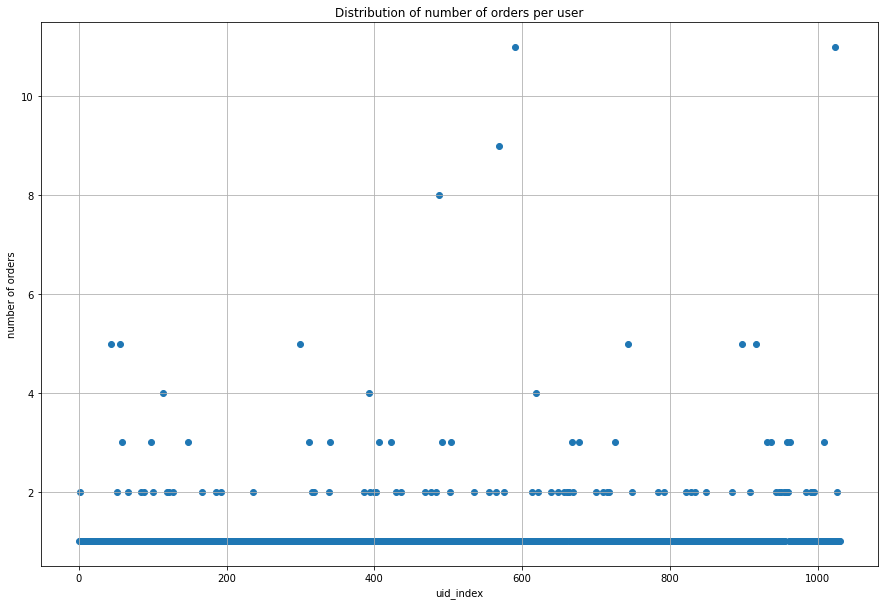

In [34]:
x_values = pd.Series(range(0,len(orders_by_users)))

plt.figure(figsize = (15,10))

plt.scatter(x_values, orders_by_users['n_orders']) 

plt.xlabel('uid_index')
plt.ylabel('number of orders')
plt.title('Distribution of number of orders per user')
plt.grid()

plt.show()

In [35]:
orders_by_users['n_orders'].value_counts()

1     937
2      64
3      17
5       6
4       3
11      2
8       1
9       1
Name: n_orders, dtype: int64

Most of the users make only 1 order and there are many users, who do 2 or 3 orders. Significantly less number of them order goods 4 or more times on the platform. There are 2 users, who have made 11 orders!

In order to work with more homogenic sample, it is better to filter out those, who make many orders, as such users can significantly change the overall picture even though there is small amount of them.

The 95-th and 99-th percentiles should be calculated to better understand the sample properties:

In [36]:
orders_by_users['n_orders'].quantile(q=[0.95,0.99])

0.95    2.0
0.99    4.0
Name: n_orders, dtype: float64

* No more than 5% of users make more than 2 orders
* No more than 1% of users make more than 4 orders

Threshold can be applyed on those, who make 4 or more orders, that will effectively filter outliers and keep around 99% of the initial data.

### Order prices

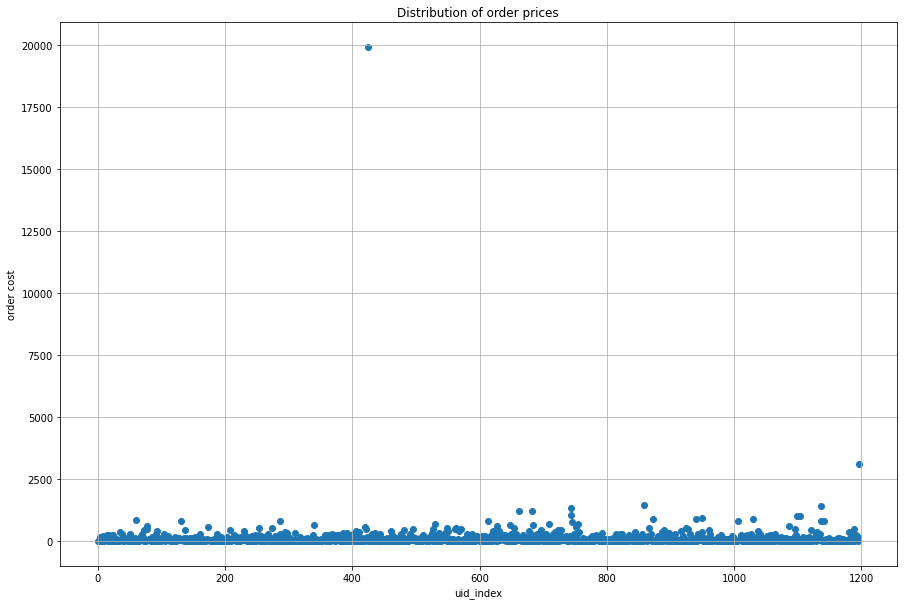

In [37]:
x_values = pd.Series(range(0,len(orders)))

plt.figure(figsize = (15,10))

plt.scatter(x_values, orders['revenue']) 

plt.xlabel('uid_index')
plt.ylabel('order cost')
plt.title('Distribution of order prices')
plt.grid()

plt.show()

1 order with a price of nearly 20000 is definitely an outlier and prevents observing the full picture, so I will add the y-axis limit at 4000:

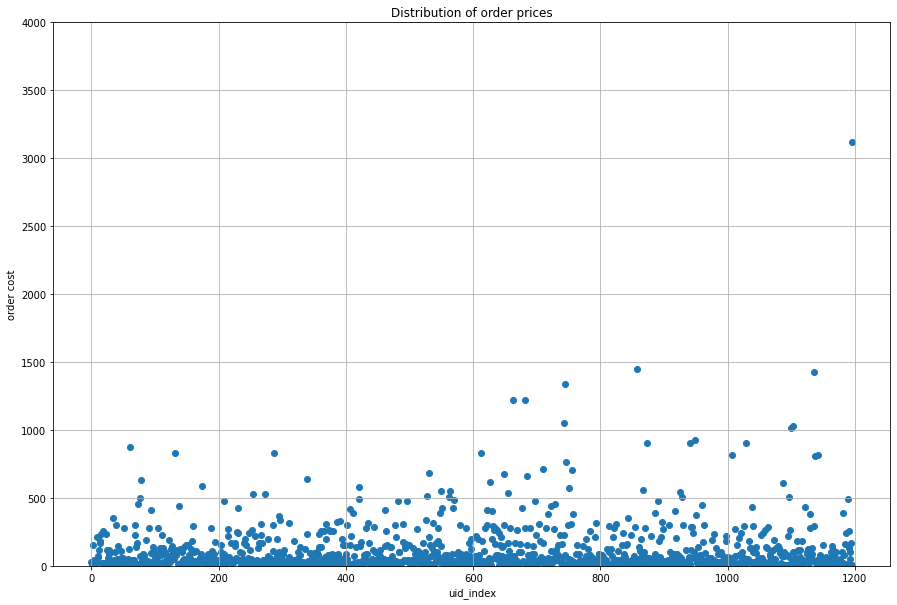

In [38]:
x_values = pd.Series(range(0,len(orders)))

plt.figure(figsize = (15,10))

plt.scatter(x_values, orders['revenue']) 

plt.xlabel('uid_index')
plt.ylabel('order cost')
plt.title('Distribution of order prices')
plt.grid()

plt.ylim(0,4000)

plt.show()

The vast majority of orders cost less than 500, but for more precise threshold applification 95-th and 99-th percentiles should be calculated:

In [39]:
orders['revenue'].quantile(q=[0.95,0.99])

0.95    435.540
0.99    900.904
Name: revenue, dtype: float64

* No more than 5% of orders cost more than 435.5
* No more than 1% of orders cost more than 900.9

I will put the threshold at the level of 500, as it is between 95-th and 99-th percentiles and it can be seen on the plot, that above this point graph is significantly more sparse, than below.

Preparing the filter for future usage:

In [40]:
# subset with users with more, than 3 orders:
users_with_many_orders =  orders_by_users[orders_by_users['n_orders']>3]['uid']
# subset with users with orders, which cost more than 500:
users_with_expensive_orders = orders[orders['revenue']>500]['uid']
# concatenating both subsets:
abnormal_users = pd.concat([users_with_many_orders, users_with_expensive_orders], axis = 0).drop_duplicates().sort_values()

In [41]:
abnormal_users.shape[0]

54

A list of 54 users, who shows abnormal behavior, is ready and will be applied futher

## Statistical comparison of groups
### Raw data
#### Conversion difference
Creating samples with number of orders done by users:

In [42]:
orders_by_users_A = orders[orders['group']=='A'].groupby('uid').agg({'transaction_id':'nunique'}).reset_index()
orders_by_users_A.columns = ['uid','n_orders']
orders_by_users_B = orders[orders['group']=='B'].groupby('uid').agg({'transaction_id':'nunique'}).reset_index()
orders_by_users_B.columns = ['uid','n_orders']

Cancatenating it with a np.array with the length equal to the number of visitors, who didn't make an order:

In [43]:
sample_A = pd.concat([orders_by_users_A['n_orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(orders_by_users_A['n_orders'])), name='n_orders')],axis=0)

sample_B = pd.concat([orders_by_users_B['n_orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(orders_by_users_B['n_orders'])), name='n_orders')],axis=0)

Calculating the statistical significance of the difference in conversion:

* **Null-hypothesis:** Conversion rate of both groups are equal
* **Alternative hypothesis:** Conversion rates of groups are unequal

In [44]:
p_value = stats.mannwhitneyu(sample_A, sample_B)[1]

print('p_value:',p_value)
print('difference:',"{0:.3f}".format(sample_B.mean()/sample_A.mean()-1)) 

if p_value > 0.05:
    print('We can\'t reject the null hypothesis')
else:
    print('We can reject the null hypothesis')

p_value: 0.016792355056752608
difference: 0.138
We can reject the null hypothesis


As the Null hypothesis here, is that conversion rates are equal for both groups, the raw data suggests, that there is the difference of 0.138 with not very strong confidence (if alpha was 0.01, there would be no significant difference).
#### Average order size difference

* **Null-hypothesis:** Average order size of both groups are equal
* **Alternative hypothesis:** Average order size of groups are different

In [45]:
p_value = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]

print('p_value:',p_value)
print('difference:','{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

if p_value > 0.05:
    print('We can\'t reject the null hypothesis')
else:
    print('We can reject the null hypothesis')

p_value: 0.6915246773264736
difference: 0.252
We can't reject the null hypothesis


Raw data didn't show statistically significant difference between average order sizes of the groups.
### Filtered data
#### Conversion difference
Running the same test, but on data with applied filter:

* **Null-hypothesis:** Conversion rate of both groups are equal
* **Alternative hypothesis:** Conversion rate of group B is greater than of group A

In [46]:
sample_A_filtered = pd.concat([orders_by_users_A[np.logical_not(orders_by_users_A['uid'].isin(abnormal_users))]['n_orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(orders_by_users_A['n_orders'])), name='n_orders')],axis=0)

sample_B_filtered = pd.concat([orders_by_users_B[np.logical_not(orders_by_users_B['uid'].isin(abnormal_users))]['n_orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(orders_by_users_B['n_orders'])), name='n_orders')],axis=0)

In [47]:
p_value = stats.mannwhitneyu(sample_A_filtered, sample_B_filtered)[1]

print('p_value:',p_value)
print('difference:',"{0:.3f}".format(sample_B_filtered.mean()/sample_A_filtered.mean()-1)) 

if p_value > 0.05:
    print('We can\'t reject the null hypothesis')
else:
    print('We can reject the null hypothesis')

p_value: 0.014254455234933103
difference: 0.155
We can reject the null hypothesis


As it was with the raw data, the null-hypothesis can be rejected, so we can assume, that difference in conversion of groups is real. After the filter was applied, p-value got a bit better, but it is still more, than 0.01. Also a differences of the mean conversions of the groups turned to be greater, than the raw data predicted (0.155 vs 0.138).

#### Average order size difference

* **Null-hypothesis:** Average order size of both groups are equal
* **Alternative hypothesis:** Average order size of group B is greater than of group A

In [48]:
orders_filtered = orders[np.logical_not(orders['uid'].isin(abnormal_users))]

p_value = stats.mannwhitneyu(orders_filtered[orders_filtered['group']=='A']['revenue'], orders_filtered[orders_filtered['group']=='B']['revenue'])[1]


print('p_value:',p_value)
print('difference:','{0:.3f}'.format(orders_filtered[orders_filtered['group']=='B']['revenue'].mean()/orders_filtered[orders_filtered['group']=='A']['revenue'].mean()-1)) 

if p_value > 0.05:
    print('We can\'t reject the null hypothesis')
else:
    print('We can reject the null hypothesis')

p_value: 0.9924791823379195
difference: 0.007
We can't reject the null hypothesis


Not only filtered data didn't show significant difference between groups' average order size, but the p_value is now greater, than it was for raw data. Also, the difference itself fell significantly, from 0.252 for raw data to 0.007 for filtered data, which is virtually none.

So there is no difference of average order size between groups.

# Conclusion
After hypothesis was checked, we can assume, that there is a detectable and significant difference in conversion rates of the groups (if alpha is 0.05, but with alpha 0.01 no signifficance would be observed). Group B shows nearly 16% bigger conversion relative to group A after outliers were dropped, saying, that we can be confident in this result.

No significant difference was found between average order sizes of the groups.

Also, relative difference in cumulative average order size clearly showed instability by the end of the experiment, which may mean, that for experiment to be conducted successfully, it could be longer. It semms for me, that indeed, a bit more information could be generated to be more confident with the results.

So, the experiment can be stopped, assuming, that group B has a greater conversion, but there is no detectable difference in average order size between groups.

In terms of questioning if the experiment was a success or a failure, the details of the hypothesis should be known - which metric was the target one.